<a href="https://colab.research.google.com/github/Olivierneeb/Segmentation-deep-learning/blob/main/Projet_segmentation_toit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet ARDF Segmentation 



## Importation



In [ ]:


import PIL
from PIL import Image
import numpy as np

import torch
import torchvision

from sklearn.metrics import confusion_matrix

# import the packages
import numpy as np
from PIL import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
import math


# import PyTorch (Deep Learning lib)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from skimage.measure import block_reduce




## Definition Fonctions Trainset / testset 

In [ ]:

def symetrie(x,y,i,j,k):
    if i==1:
        x,y = np.transpose(x,axes=(1,0,2)),np.transpose(y,axes=(1,0))
    if j==1:
        x,y = np.flip(x,axis=1),np.flip(y,axis=1)
    if k==1:
        x,y = np.flip(x,axis=1),np.flip(y,axis=1)
    return x.copy(),y.copy()
    


class ISPRS: 
    def __init__(self):
        self.nbimage = {}
        self.nbimage["train"]=14
        self.nbimage["test"]=10
        
        self.ROOT = "/content/drive/My Drive/projet_ardf/" # "SET_THE_PATH_TO_THE_DATA/"
    
    
    def getImageAndLabel(self,flag,num,innumpy=True):
        assert(flag in ["train","test"])
        assert(num < self.nbimage[flag])
        
        image = PIL.Image.open(self.ROOT+flag+"/"+str(num)+"_x.png").convert("RGB").copy()
        image = np.asarray(image,dtype=np.uint8) #warning wh swapping

        label = PIL.Image.open(self.ROOT+flag+"/"+str(num)+"_y.png").convert("RGB").copy()
        label = np.asarray(label,dtype=np.uint8) #warning wh swapping
        
        label = np.uint8(label!=0) # 0 pour le noir 1 pour le reste

        if innumpy:
            return image, label
        else:
            image = torch.Tensor(np.transpose(image,axes=(2, 0, 1))).unsqueeze(0)
            return image, label


    def getrawrandomtiles(self,nbtiles,tilesize):
        XY = []
        nbtilesperimage = nbtiles//14+1
        num=0
        #crop
        for num in range(14):
            image,label = self.getImageAndLabel("train",num)
            label = label[:,:,0]

            row = np.random.randint(0,image.shape[0]-tilesize-2,size = nbtilesperimage)
            col = np.random.randint(0,image.shape[1]-tilesize-2,size = nbtilesperimage)

            for i in range(nbtilesperimage):
                im = image[row[i]:row[i]+tilesize,col[i]:col[i]+tilesize,:].copy()
                mask = label[row[i]:row[i]+tilesize,col[i]:col[i]+tilesize].copy()
                XY.append((im,mask))

        #symetrie
        symetrieflag = np.random.randint(0,2,size = (len(XY),3))
        XY = [(symetrie(x,y,symetrieflag[i][0],symetrieflag[i][1],symetrieflag[i][2])) for i,(x,y) in enumerate(XY)]
        return XY


    def getrandomtiles(self,nbtiles,tilesize,batchsize): # ,128,32
        XY = self.getrawrandomtiles(nbtiles,tilesize)

        X = torch.stack([torch.Tensor(np.transpose(x,axes=(2, 0, 1))).cpu() for x,y in XY])
        Y = torch.stack([torch.from_numpy(y).long().cpu() for x,y in XY])

        dataset = torch.utils.data.TensorDataset(X,Y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True, num_workers=2)

        return dataloader
        


# Fonctions ajoutées pour load le test set 
    def test_getrawrandomtiles(self,nbtiles,tilesize):
        
        XY = []
        nbtilesperimage = nbtiles//10+1
        num=0
        #crop
        for num in range(10):
            image,label = self.getImageAndLabel("test",num)
            label = label[:,:,0]

            row = np.random.randint(0,image.shape[0]-tilesize-2,size = nbtilesperimage)
            col = np.random.randint(0,image.shape[1]-tilesize-2,size = nbtilesperimage)

            for i in range(nbtilesperimage):
                im = image[row[i]:row[i]+tilesize,col[i]:col[i]+tilesize,:].copy()
                mask = label[row[i]:row[i]+tilesize,col[i]:col[i]+tilesize].copy()
                XY.append((im,mask))

        #symetrie
        symetrieflag = np.random.randint(0,2,size = (len(XY),3))
        XY = [(symetrie(x,y,symetrieflag[i][0],symetrieflag[i][1],symetrieflag[i][2])) for i,(x,y) in enumerate(XY)]
        return XY

    def test_getrandomtiles(self,nbtiles,tilesize,batchsize):
        XY = self.test_getrawrandomtiles(nbtiles,tilesize)

        X = torch.stack([torch.Tensor(np.transpose(x,axes=(2, 0, 1))).cpu() for x,y in XY])
        Y = torch.stack([torch.from_numpy(y).long().cpu() for x,y in XY])

        dataset = torch.utils.data.TensorDataset(X,Y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True, num_workers=2)

        return dataloader
# stop fonction test set  


# Fonction matrice de confusion non utilisée
    def getPerformances(self,flag="test"): 
        #### produisez des cartes et mettez les à coter des images 0_x.png -> 0_z.png
        
        matriceconfusion = np.zeros((2,2),dtype=int)

        for num in range(10):
            label = PIL.Image.open(self.ROOT+flag+"/"+str(num)+"_y.png").convert("RGB").copy()
            label = np.asarray(label,dtype=np.uint8) # warning wh swapping
            
            pred = PIL.Image.open(self.ROOT+flag+"/"+str(num)+"_z.png").convert("RGB").copy()
            pred = np.asarray(pred,dtype=np.uint8) # warning wh swapping
            
            label = np.uint8(label!=0)
            label = label[:,:,0]

            pred = np.uint8(pred!=0)
            pred = pred[:,:,0]
            
            matriceconfusion += confusion_matrix(label.flatten(),pred.flatten(),[0,1])
            
        return matriceconfusion


## Connexion Drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Visualisation des données 



In [ ]:
# declaration des train set / test set 

trainload = ISPRS()

train_loader = trainload.getrandomtiles(500 , 256 , 14) # 500 images de train, réparties en batch de 14 images de 256x256

test_loader = trainload.test_getrandomtiles(50 , 256, 9) # 50 images de test

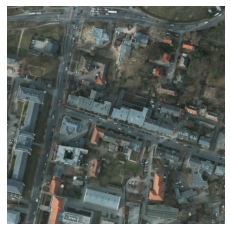

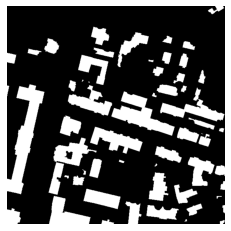

In [ ]:
# Visualisation une image 

image_test,label_test = trainload.getImageAndLabel(flag ="train",num = 5)

plt.figure()
plt.imshow(image_test)
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(label_test*255)
plt.axis('off')
plt.show()

torch.Size([14, 3, 256, 256])
torch.Size([14, 256, 256])
torch.Size([14, 1, 256, 256])


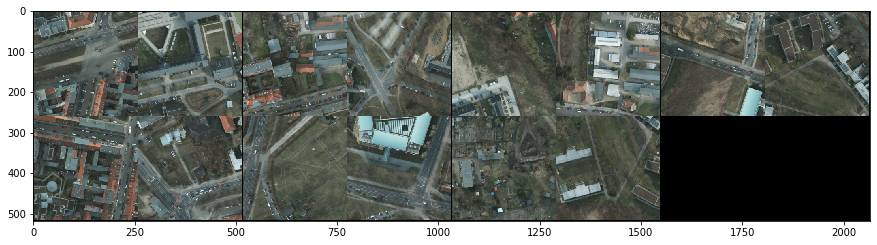

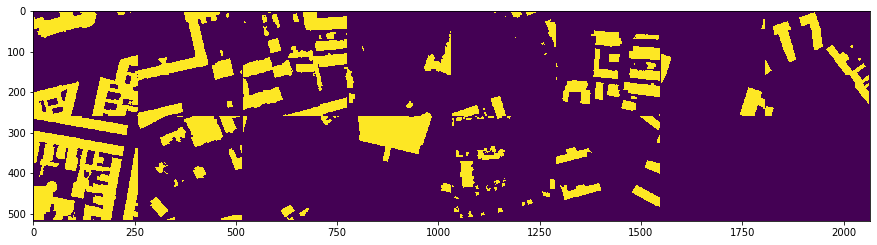

In [ ]:
# Affichage d'une grille d'images et de labels

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1,2,0))/255, interpolation='nearest')

def show_label(img):
    npimg = img.detach().numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1,2,0))[:,:,0], interpolation='nearest')

sample, label  =   next(iter(train_loader))

# premier batch du dataset 
show(torchvision.utils.make_grid(sample)) # grille de 14 images 
print(sample.shape) # shape du batch 
print(label.shape)
print(label[:,None,:,:].shape) # torch.Size([42, 1, 128, 128])
show_label(torchvision.utils.make_grid(label[:,None,:,:]))  # grille de 14 labels


Auto encodeur, 600*600 =>
compression l'information pour faire de la classification dans l'espace de faible dimension

On compresse, puis on branche sur un décodeur, et on vise à créer une image binaire de même que l'entrée.



Moins de  couches et il faut arrriver au  prie à 4x4 pixels.



max_pool divise par 2,


image en entrée de taille 128x128, et nn.Conv2d(128, 256, kernel_size=3, padding=1), 128 à 256 couleurs. 


dataloader = getrandomtiles(


## Creation du Unet 

In [ ]:
# create the neural network with Pytorch
class Unet(nn.Module):
  """Unet segmentation network."""

  def __init__(self, in_channels, out_channels):
    """Init Unet fields."""
    super(Unet, self).__init__()

    self.in_channels = in_channels

    self.conv11 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
    self.bn11 = nn.BatchNorm2d(64)
    self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.bn12 = nn.BatchNorm2d(64)

    self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn21 = nn.BatchNorm2d(128)
    self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.bn22 = nn.BatchNorm2d(128)

    self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.bn31 = nn.BatchNorm2d(256)
    self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.bn32 = nn.BatchNorm2d(256)
    self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.bn33 = nn.BatchNorm2d(256)

    self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.bn41 = nn.BatchNorm2d(512)
    self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn42 = nn.BatchNorm2d(512)
    self.conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn43 = nn.BatchNorm2d(512)

    self.conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn51 = nn.BatchNorm2d(512)
    self.conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn52 = nn.BatchNorm2d(512)
    self.conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn53 = nn.BatchNorm2d(512)

    self.upconv5 = nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1, stride=2, output_padding=1)

    self.conv53d = nn.ConvTranspose2d(1024, 512, kernel_size=3, padding=1)
    self.bn53d = nn.BatchNorm2d(512)
    self.conv52d = nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1)
    self.bn52d = nn.BatchNorm2d(512)
    self.conv51d = nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1)
    self.bn51d = nn.BatchNorm2d(512)

    self.upconv4 = nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1, stride=2, output_padding=1)

    self.conv43d = nn.ConvTranspose2d(1024, 512, kernel_size=3, padding=1)
    self.bn43d = nn.BatchNorm2d(512)
    self.conv42d = nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1)
    self.bn42d = nn.BatchNorm2d(512)
    self.conv41d = nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1)
    self.bn41d = nn.BatchNorm2d(256)

    self.upconv3 = nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1, stride=2, output_padding=1)

    self.conv33d = nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1)
    self.bn33d = nn.BatchNorm2d(256)
    self.conv32d = nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1)
    self.bn32d = nn.BatchNorm2d(256)
    self.conv31d = nn.ConvTranspose2d(256,  128, kernel_size=3, padding=1)
    self.bn31d = nn.BatchNorm2d(128)

    self.upconv2 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

    self.conv22d = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
    self.bn22d = nn.BatchNorm2d(128)
    self.conv21d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
    self.bn21d = nn.BatchNorm2d(64)

    self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

    self.conv12d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
    self.bn12d = nn.BatchNorm2d(64)
    self.conv11d = nn.ConvTranspose2d(64, out_channels, kernel_size=3, padding=1)

    # # This is the modification added to Unet, for SR
    # self.upconv0 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1, stride=2, output_padding=1)
    

  def forward(self, x):
    """Forward method."""
    # Stage 1
    x11 = F.relu(self.bn11(self.conv11(x)))
    x12 = F.relu(self.bn12(self.conv12(x11)))
    x1p = F.max_pool2d(x12, kernel_size=2, stride=2)

    # Stage 2
    x21 = F.relu(self.bn21(self.conv21(x1p)))
    x22 = F.relu(self.bn22(self.conv22(x21)))
    x2p = F.max_pool2d(x22, kernel_size=2, stride=2)

    # Stage 3
    x31 = F.relu(self.bn31(self.conv31(x2p)))
    x32 = F.relu(self.bn32(self.conv32(x31)))
    x33 = F.relu(self.bn33(self.conv33(x32)))
    x3p = F.max_pool2d(x33, kernel_size=2, stride=2)

    # Stage 4
    x41 = F.relu(self.bn41(self.conv41(x3p)))
    x42 = F.relu(self.bn42(self.conv42(x41)))
    x43 = F.relu(self.bn43(self.conv43(x42)))
    x4p = F.max_pool2d(x43, kernel_size=2, stride=2)

    # Stage 5
    x51 = F.relu(self.bn51(self.conv51(x4p)))
    x52 = F.relu(self.bn52(self.conv52(x51)))
    x53 = F.relu(self.bn53(self.conv53(x52)))
    x5p = F.max_pool2d(x53, kernel_size=2, stride=2)

    # Stage 5d
    x5d = torch.cat((self.upconv5(x5p), x53), 1)
    x53d = F.relu(self.bn53d(self.conv53d(x5d)))
    x52d = F.relu(self.bn52d(self.conv52d(x53d)))
    x51d = F.relu(self.bn51d(self.conv51d(x52d)))

    # Stage 4d
    x4d = torch.cat((self.upconv4(x51d), x43), 1)
    x43d = F.relu(self.bn43d(self.conv43d(x4d)))
    x42d = F.relu(self.bn42d(self.conv42d(x43d)))
    x41d = F.relu(self.bn41d(self.conv41d(x42d)))

    # Stage 3d
    x3d = torch.cat((self.upconv3(x41d), x33), 1)
    x33d = F.relu(self.bn33d(self.conv33d(x3d)))
    x32d = F.relu(self.bn32d(self.conv32d(x33d)))
    x31d = F.relu(self.bn31d(self.conv31d(x32d)))

    # Stage 2d
    x2d = torch.cat((self.upconv2(x31d), x22), 1)
    x22d = F.relu(self.bn22d(self.conv22d(x2d)))
    x21d = F.relu(self.bn21d(self.conv21d(x22d)))

    # print(x21d.shape)

    # Stage 1d
    x1d = torch.cat((self.upconv1(x21d), x12), 1)
    x12d = F.relu(self.bn12d(self.conv12d(x1d)))
    x11d = self.conv11d(x12d)
    
    # ### Modification to Unet for SR
    # y = self.upconv0(x11d)
    # print(y.shape)

    return x11d

    

In [ ]:
# actual network creation
net = Unet(3,1)
net.cuda() # go GPU


Unet(
  (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn21): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn22): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn31): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn32): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
# # create the optimizer
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

## Apprentissage du Unet


In [ ]:
nb_epoch = 12              # converge au bout de 12
nb_affiche_resultat = 1    # affiche des images "test" toutes les époques

lr = 1e-3 # 1e-3
weight_decay = 1e-6

optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay = weight_decay) # try AdamW  
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = lr, steps_per_epoch = len(train_loader), epochs = nb_epoch, pct_start=0.2)
# warm up de 20% 

loss_fn = nn.BCEWithLogitsLoss()
# scaler = torch.cuda.amp.GradScaler() pas utile dans notre cas 

In [ ]:
# Fonction calculant la loss sur le test set

def test_on_testset (test_loader): 
  l_loss_test = [] 
  l_loss_F = []

  for sample,label in test_loader : 

      inputs = sample 
      outputs = net(inputs.cuda())
      loss = loss_fn(outputs, label.float().cuda().unsqueeze(1))
      l_loss_F.append(loss.item())
      print(loss.item())
  
  return (  np.mean(l_loss_F  ) )


In [ ]:
# Epoch loops 


l_loss_iter = []
l_loss_testset = []

for i in range(nb_epoch):
  print(f'epoch n°{i}')
  t = time.time()

  for sample,label in train_loader : # sample de 14 images, parmi le trainloader contenant les 500 images
    
    net.train()

    inputs = sample 
    outputs = net(inputs.cuda())
    
    # reinitialize the gradients
    optimizer.zero_grad()

    loss = loss_fn(outputs, label.float().cuda().unsqueeze(1))
    l_loss_iter.append(loss.item())

    # compute the gradients
    loss.backward()
    
    # update the weights
    optimizer.step()
    scheduler.step()

    net.eval()

    l_loss_testset.append(test_on_testset(test_loader))

 
  elapsed = time.time() - t
  
  print(f'temps pour une epoch {round(elapsed,2)}')



epoch n°0
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
temps pour une epoch 50.35
epoch n°1
la loss est de taille 7
la loss est de taille 7
la loss est de taille 7
la loss est de ta

## Résultats de l'apprentissage 

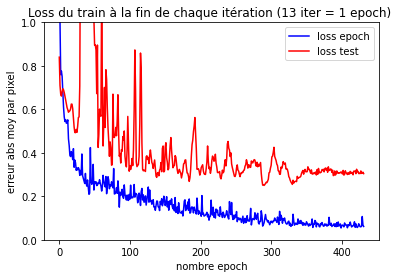

In [ ]:
# Loss du Train / itération 
plt.plot([j for j in range(len(l_loss_iter))], l_loss_iter,'b', label='loss epoch')
plt.plot([j for j in range(len(l_loss_testset))], l_loss_testset,'r', label = 'loss test')
plt.title('Loss du train à la fin de chaque itération (13 iter = 1 epoch) ')
plt.legend()
plt.ylim(  0, 1 )
plt.xlabel('nombre epoch')
plt.ylabel('erreur abs moy par pixel')
plt.show()

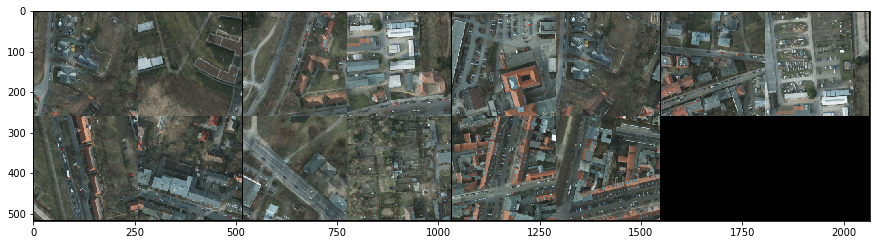

In [ ]:
# show un sample 
show( torchvision.utils.make_grid(sample))

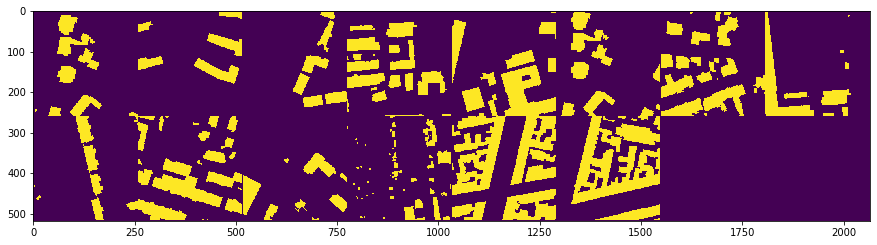

In [ ]:
# show d'un label  
show_label(torchvision.utils.make_grid(label[:,None,:,:])) # torch.Size([42, 1, 128, 128])

In [ ]:
outputs.cpu().detach().numpy().shape

(14, 1, 256, 256)

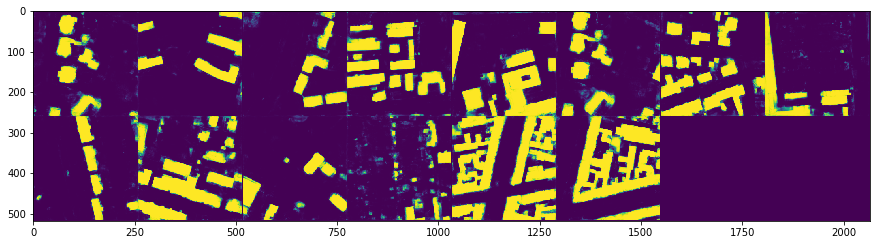

In [ ]:
# show sigmoid( outputs )
show_label(torchvision.utils.make_grid( torch.sigmoid( outputs.cpu()) )) # torch.Size([42, 1, 128, 128])

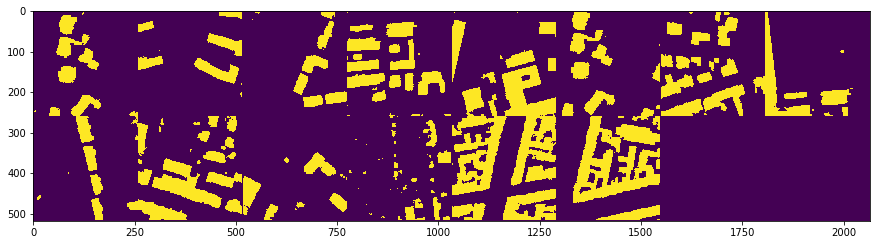

In [ ]:
# show outputs positifs 
outputs_positifs = torch.sigmoid( outputs.cpu()) 
outputs_positifs[outputs_positifs >0.5]=1
outputs_positifs[outputs_positifs <0.5]=0
show_label(torchvision.utils.make_grid( outputs_positifs )) # torch.Size([42, 1, 128, 128])

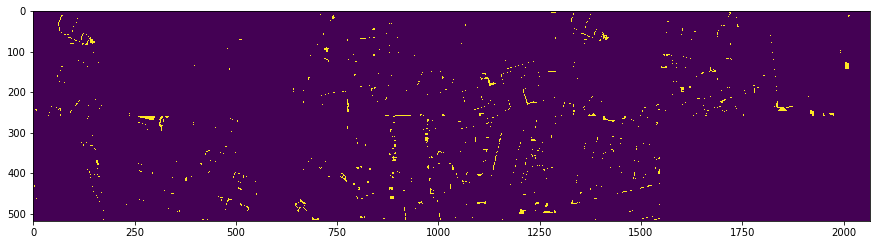

In [ ]:
# show les zones de label manquées 
positifs_manques  =   label[:,None,:,:] - torch.sigmoid( outputs.cpu())
positifs_manques[ positifs_manques >0.5]=1
positifs_manques[positifs_manques<0.5]=0
show_label(torchvision.utils.make_grid( positifs_manques ))

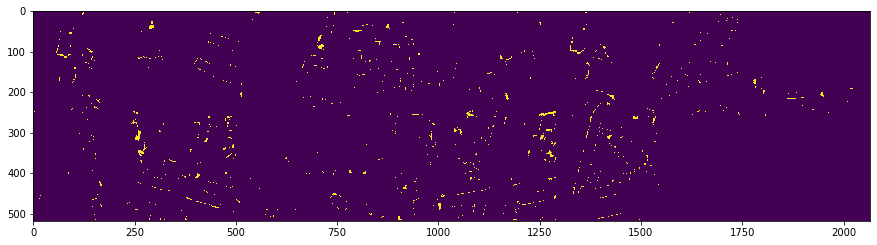

In [ ]:
# show les zones de output en trop  

## a faire !! 
positifs_manques  =    torch.sigmoid( outputs.cpu()) - label[:,None,:,:]
positifs_manques[positifs_manques>0.5]=1
positifs_manques[positifs_manques<0.5]=0
show_label(torchvision.utils.make_grid( positifs_manques ))

In [ ]:
a = torch.sigmoid( outputs.cpu())
a.shape


torch.Size([14, 1, 256, 256])

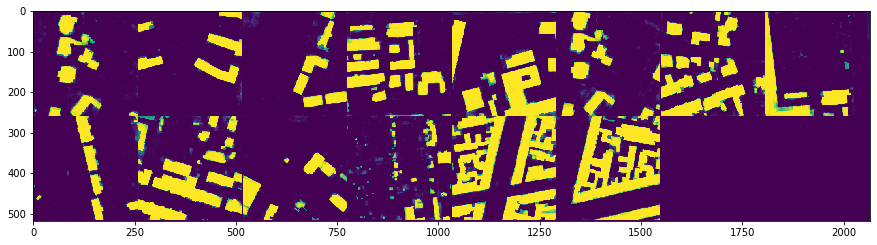

In [ ]:
# Demi teinte 
demi_teinte  =  label[:,None,:,:]*255*1/2 + torch.sigmoid( outputs.cpu()) *255*1/2
show_label(torchvision.utils.make_grid( demi_teinte ))

In [ ]:
# plt.imshow( outputs.cpu().detach().numpy()*255/2 + label.numpy()*255/2 )
# plt.imshow(outputs.cpu().detach().numpy()[0,0,:,:],cmap='gray')
# outputs_np = torch.sigmoid( outputs.cpu()).detach().numpy()[0,0,:,:]

## Résultats sur le Test set 

In [ ]:

for sample,label in test_loader : 

    inputs = sample 
    outputs = net(inputs.cuda())
    loss = loss_fn(outputs, label.float().cuda().unsqueeze(1))
    l_loss_F.append(loss.item())
    
  print(f"la loss est de taille {len(l_loss_F)}")
  return (  np.mean(l_loss_F  ) )


In [ ]:
l_loss_testset[-1]

0.30433185398578644

In [ ]:
test_on_testset(test_loader )

0.16528193652629852
0.16877491772174835
0.4458635747432709
0.17269177734851837
0.4969436824321747
0.48627614974975586
0.21829478442668915


0.30773240327835083

In [ ]:
sample, label = iter(test_loader)

ValueError: ignored

In [ ]:
sample_test.shape

NameError: ignored

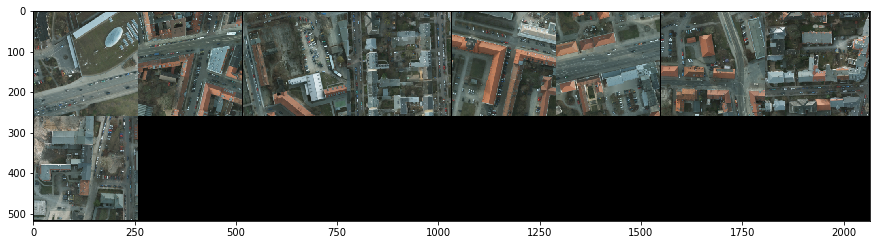

In [ ]:
# visualisation sur le test set 

sample_test, label = next(iter(test_loader))

show(torchvision.utils.make_grid(sample_test))

In [ ]:
label.shape

In [ ]:
output_test = net(sample_test.cuda())
output_test.shape

In [ ]:
show_label(torchvision.utils.make_grid(label[:,None,:,:]))

In [ ]:
show_label(torchvision.utils.make_grid( torch.sigmoid( output_test.cpu()) )) # torch.Size([42, 1, 128, 128])

In [ ]:
# show les zones de label manquées 
positifs_manques  =   label[:,None,:,:] - torch.sigmoid( output_test.cpu())
mask = (positifs_manques < 0.5) & (positifs_manques  > -0.5)
positifs_manques_essai  = positifs_manques[:]

positifs_manques_essai[mask]  = 1
positifs_manques_essai[~mask]  = 0

show_label(torchvision.utils.make_grid( positifs_manques_essai ))

In [ ]:
# show outputs positifs 
outputs_positifs = torch.sigmoid( output_test.cpu()) 
outputs_positifs[outputs_positifs >0.5]=1
outputs_positifs[outputs_positifs <0.5]=0
show_label(torchvision.utils.make_grid( outputs_positifs )) # torch.Size([42, 1, 128, 128])